# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project: Anomalies Detection using Autoencoders

## Notebook 3: Credit Card Fraud Detection with Autoencoders

## Yuri Balasanov, Andrey Kobyshev, &copy; iLykei 2018

This notebook shows how to use autoencoders to detect anomalies in creadit cards transactions data.

Used source is the [post by Venelin Valkov](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd).  Code from the post is modified for the purposes of the project.

Other useful sources:
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
- [Stacked Autoencoders in TensorFlow](http://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)

In order to detect anomalies autoencoder needs to be trained in unsupervised (or semi-supervised) fashion on data free of anomalies. The trained model is then used to predict normal data mixed with anomalies. Cases which the model fails to predict are marked as anomalies.

In case of pre-labeled and anonymized dataset of creadit cards transactions anomalies are fraud instances.

# Setup


In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import h5py
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


# Loading the data

The dataset `creditcard.csv` can be downloaded from [this link](https://www.kaggle.com/mlg-ulb/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 labeled frauds out of 284,807 transactions.

All variables in the dataset are numeric. The data have been transformed using PCA for privacy reasons. The two features that have not been changed are Time and Amount. Variable Time shows time between the current transaction and the first transaction in the dataset in seconds.

In [2]:
df = pd.read_csv("creditcard.csv")

# Data exploration

Explore the data.

In [3]:
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The file contains 31 columns of which 3 are Time, Amount and class. The rest are features transformed by PCA. 

Check for missing values:

In [4]:
df.isnull().values.any()

False

Check how large are the classes.

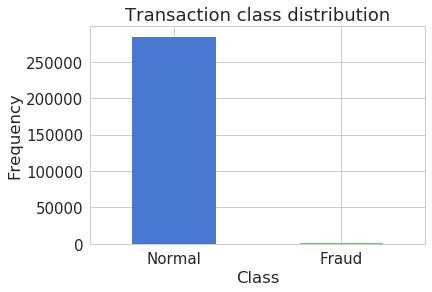

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
rcParams['figure.figsize'] = 14, 8
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

The dataset is highly imbalanced: it has a lot more normal transactions than fraudulent ones.  

Create subsets by class variable:

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [7]:
frauds.shape

(492, 31)

In [8]:
normal.shape

(284315, 31)

How different are the amounts of money used in different transaction classes?

In [9]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Summary statistics are not equivalent, but they do not seem to be different enough to draw reliable conclusions.

Compare empirical distributions of the transaction amounts in each class:

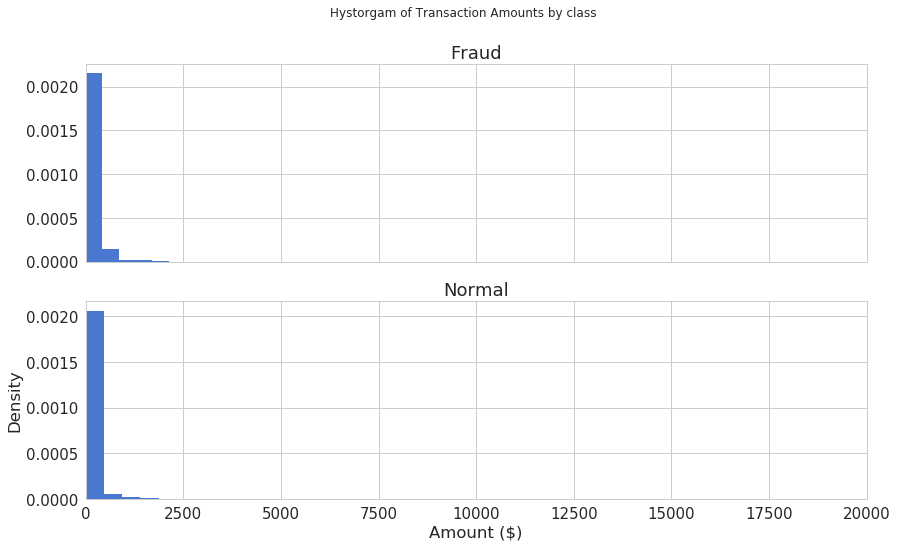

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Hystorgam of Transaction Amounts by class')

plt.xlabel('Amount ($)')
plt.ylabel('Density')
plt.xlim((0, 20000))

ax1.hist(frauds.Amount, bins = 5, density=True)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = 55, density=True)
ax2.set_title('Normal')
plt.show();

Both distributions look like exponential. Compare rough estimates of intensity parameters of exponential distributions of amounts:

In [12]:
intensity_normal = 1/np.mean(normal.Amount)
intensity_frauds = 1/np.mean(frauds.Amount)

print('Normal: ',intensity_normal, 'Fraud: ',intensity_frauds)

Normal:  0.011326179860244498 Fraud:  0.008182547988897679


Amounts of normal transactions have heavier upper tail than amounts of fraudulent transactions. But the difference is not large enough.

Compare the classes by time of transaction and amount on th following graph.

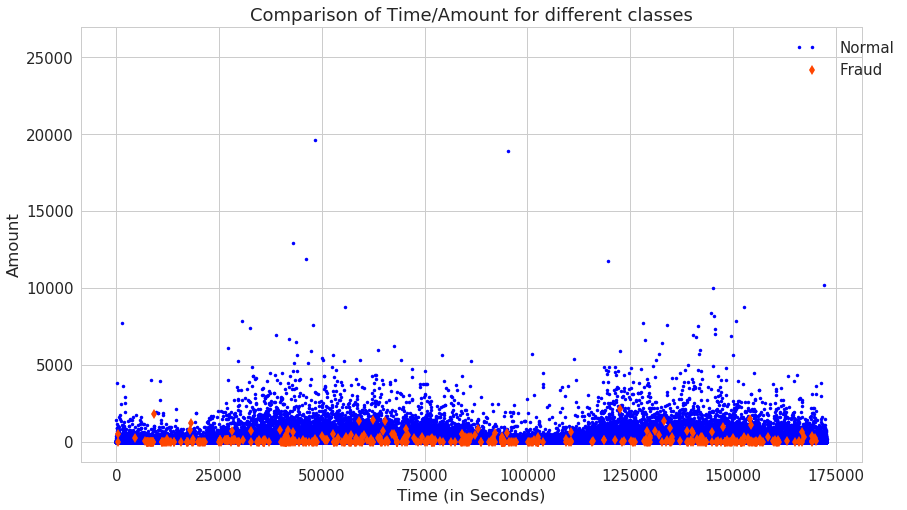

In [13]:
groups = df.groupby('Class')
fig, ax = plt.subplots()
for name, group in groups:
     if name == 1:
         MarkerSize = 7
         Color = 'orangered'
         Label = 'Fraud'
         Marker = 'd'
     else:
         MarkerSize = 3.5
         Color = 'b'
         Label = 'Normal'
         Marker = 'o'
     ax.plot(group.Time, group.Amount,
             linestyle='',
             color=Color,
             label=Label,
             ms=MarkerSize,
             marker=Marker)
ax.legend(loc='upper left', bbox_to_anchor=(0.9, 1))
plt.title("Comparison of Time/Amount for different classes")
plt.ylabel('Amount')
plt.xlabel('Time (in Seconds)')
plt.show();


Time of transaction does not seem to matter. Amounts of fraudulent transactions are small and well mixed with majority of normal transactions to avoid extra attention. Latter is consistent with the distribution analyses for transactions amounts.

# Autoencoders

Detect anomalies using similar architecture of autoencoder to the one used earlier for MNIST data:

![Stacked Autoencoder](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FStackedAE.jpg)

# Preparing the data

Drop column Time since it does not seem to be informative. Scale variable Amount using scikit's StandardScaler: z-score the variable.

In [14]:
df.shape

(284807, 31)

In [15]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


Training an autoencoder for anomalies detection is done using only normal data. Then any new observations that cannot be well predicted by such autoencoder are anomalies.

Such approach has two important benefits in comparison to classifiers: 
- Imbalance of the data is not a problem: there is plenty of data to train the model
- Anomalies detection is not trained for any particular type of anomaly: anything that is different from normal can be detected

Reserve 20% of the data for testing. Parameter `stratify` helps keeping the class size ratio within each data set.

In [16]:
X_train_split, X_test_split = train_test_split(data, test_size=0.2,
                                   stratify=data['Class'], 
                                   random_state=RANDOM_SEED)

Extract the labels from train and test data.

In [17]:
y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'], axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (227845, 29) , shape Y (227845,)
Test: shape X (56962, 29) , shape Y (56962,)


In [18]:
X_trainNorm = X_train[y_train == 0]
X_trainNorm_val = X_trainNorm.values # Only values, axes labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data

In [19]:
print(y_train.shape)
print(X_train.shape)

(227845,)
(227845, 29)


In [20]:
X_trainNorm_val.shape

(227451, 29)

# Creating the model

This autoencoder contains fully connected layers with 14, 7, 14 and 29 neurons, respectively.  The first two layers make encoder, the last two make decoder. 

Training is done with $L_1$ regularization.

Set parameters:

In [21]:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 14
encoder_dim = 7

Create tensors:

In [22]:
input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(encoder_dim, activation="relu")(encoder1)
decoder1 = Dense(layer1_dim, activation='tanh')(encoder2)
decoder2 = Dense(input_dim, activation='linear')(decoder1)
print('input_layer: ',input_layer)
print('encoder1',encoder1)
print('encoder2',encoder2)
print('decoder1',decoder1)
print('decoder2',decoder2)

input_layer:  Tensor("input_1:0", shape=(?, 29), dtype=float32)
encoder1 Tensor("dense_1/Tanh:0", shape=(?, 14), dtype=float32)
encoder2 Tensor("dense_2/Relu:0", shape=(?, 7), dtype=float32)
decoder1 Tensor("dense_3/Tanh:0", shape=(?, 14), dtype=float32)
decoder2 Tensor("dense_4/BiasAdd:0", shape=(?, 29), dtype=float32)


Create autoencoder from the tensors:

In [23]:
autoencoder = Model(inputs=input_layer, outputs=decoder2)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_4 (Dense)              (None, 29)                435       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________


Train the model for 100 epochs with a batch size of 32 samples and save the best performing model to a file using ModelCheckpoint provided by Keras. 

Use the EarlyStopping callback that stops training when a monitored quantity has stopped improving.

In [24]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0) # 'patience' number of not improving epochs
history = autoencoder.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               earlystopping]).history

Train on 227451 samples, validate on 56864 samples
Epoch 1/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.5693 - val_loss: 0.4634
Epoch 2/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.4325 - val_loss: 0.4015
Epoch 3/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.3935 - val_loss: 0.3859
Epoch 4/100
227451/227451 [==============================] - 8s 35us/step - loss: 0.3794 - val_loss: 0.3713
Epoch 5/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.3711 - val_loss: 0.3677
Epoch 6/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.3650 - val_loss: 0.3577
Epoch 7/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.3608 - val_loss: 0.3519
Epoch 8/100
227451/227451 [==============================] - 8s 36us/step - loss: 0.3569 - val_loss: 0.3565


Load the model saved by `checkpointer`.

In [25]:
autoencoder = load_model('model.h5')

# Inside the autoencoder. 

What happens to the data inside the autoencoder? 

Find that out using this <a href="https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FAutoencodersShiny.html" target="_blank">application</a> or below:

In [26]:
from IPython.display import IFrame
IFrame('https://shiny.ilykei.com/LVShiny/Autoencoders/', 800, 1220)

# Evaluation

Visualize the learning process.

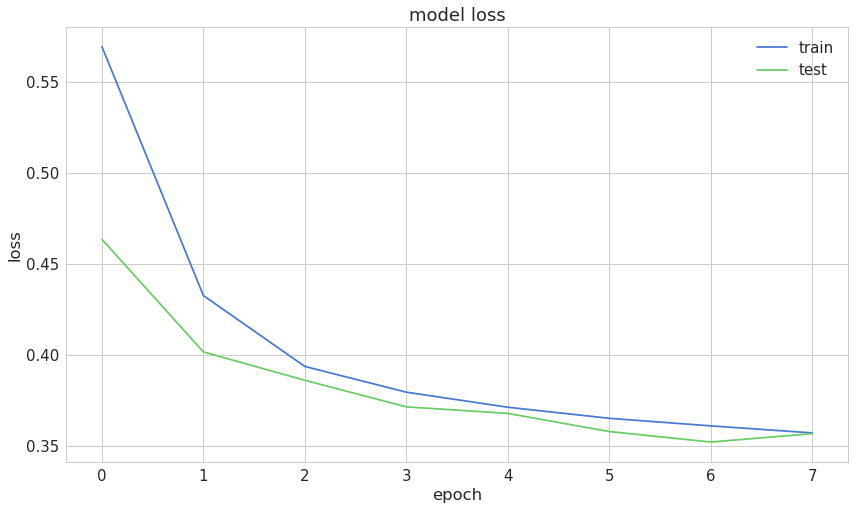

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction errors on both train and test data converge nicely. 

Calculate predictions by the autoencoder:

In [28]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

((56962, 29), (56962, 29))

Calculate **mean squared error**.

In [29]:
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
263020,0.125071,0
11378,0.563560,0
147283,0.422296,0
219439,0.099698,0
36939,1.099127,0


In [30]:
error_df.shape

(56962, 2)

In [31]:
error_df.reconstruction_error.describe()

count    56962.000000
mean         0.387376
std          2.157090
min          0.015042
25%          0.135391
50%          0.213681
75%          0.347426
max        159.366045
Name: reconstruction_error, dtype: float64

## Reconstruction errors for normal transactions

Plot histogram of errors of reconstruction for normal data.

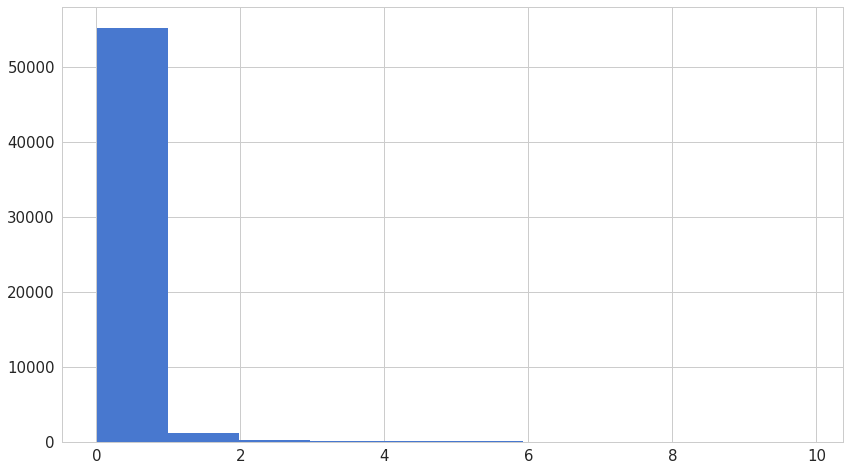

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
ax.hist(normal_error_df.reconstruction_error.values, bins=10);

## Reconstruction errors for fraudulent transactions

Compare distribution of reconstruction error for normal data and for fraudulent data.

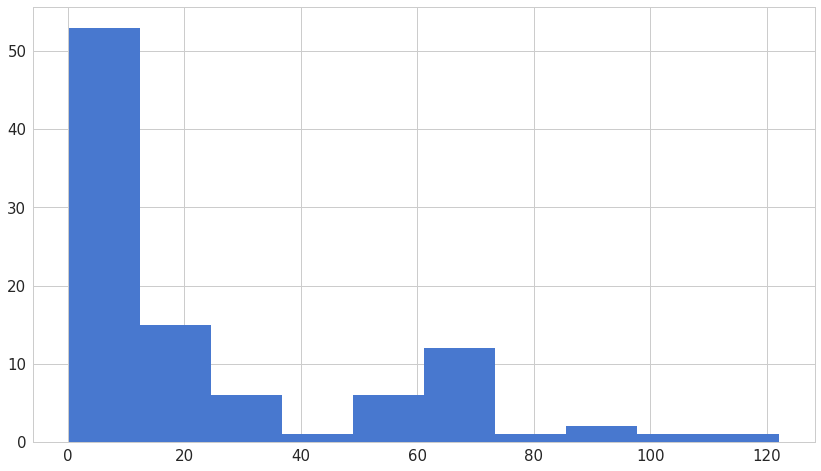

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
ax.hist(fraud_error_df.reconstruction_error.values, bins=10);

Errors of reconstruction of fraudulent data are much larger.

In [34]:
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

Calculate ROC curve and AUC:

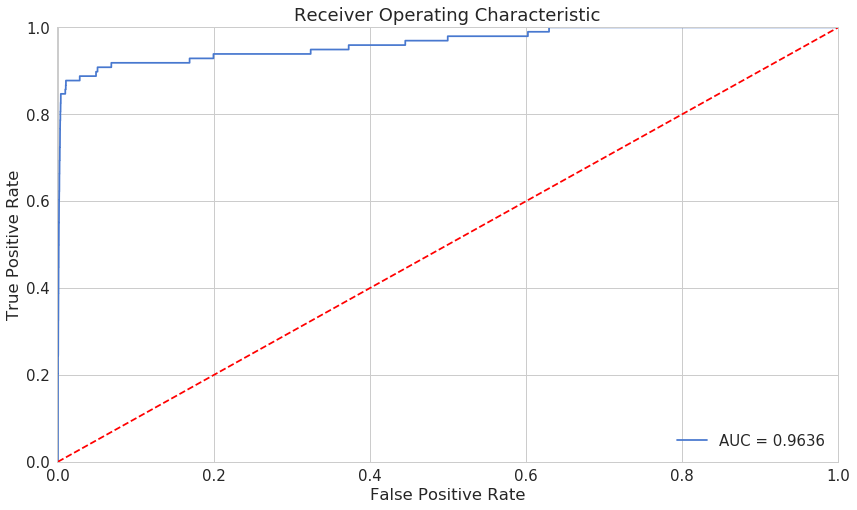

In [35]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

A AUC for the autoencoder predictions is pretty high.

# Prediction

To detect fraud based on prediction MSE select a high level quantile of the MSE sample that guarantees probability of type 1 error. Select 0.99 quantile of the reconstruction error for "normal" class.

In [36]:
threshold = normal_error_df.reconstruction_error.quantile(q=0.995)
threshold

2.6011491489272323

Plot all errors, normal and fraud cases marked, and the threshold:

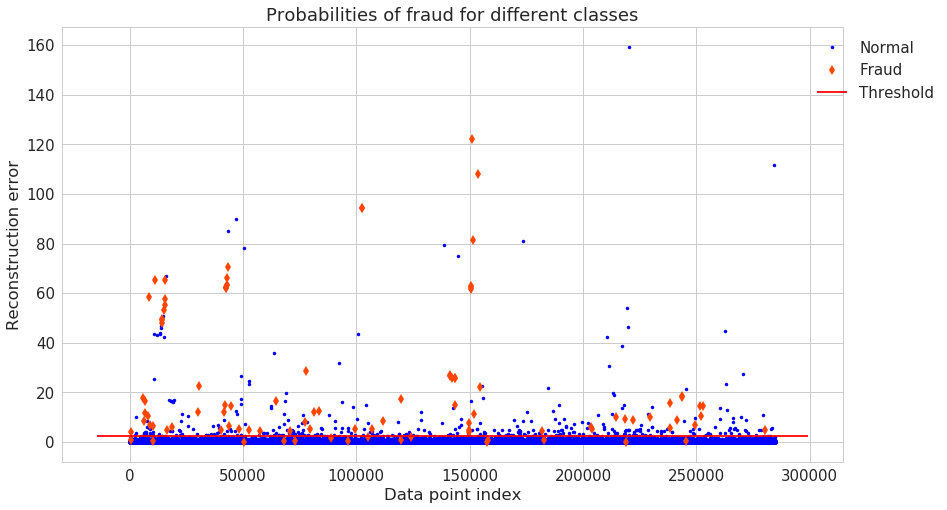

In [37]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    if name == 1:
        MarkerSize = 7
        Color = 'orangered'
        Label = 'Fraud'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(loc='upper left', bbox_to_anchor=(0.95, 1))
plt.title("Probabilities of fraud for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

To draw more precise conclusions calculate confusion matrix:

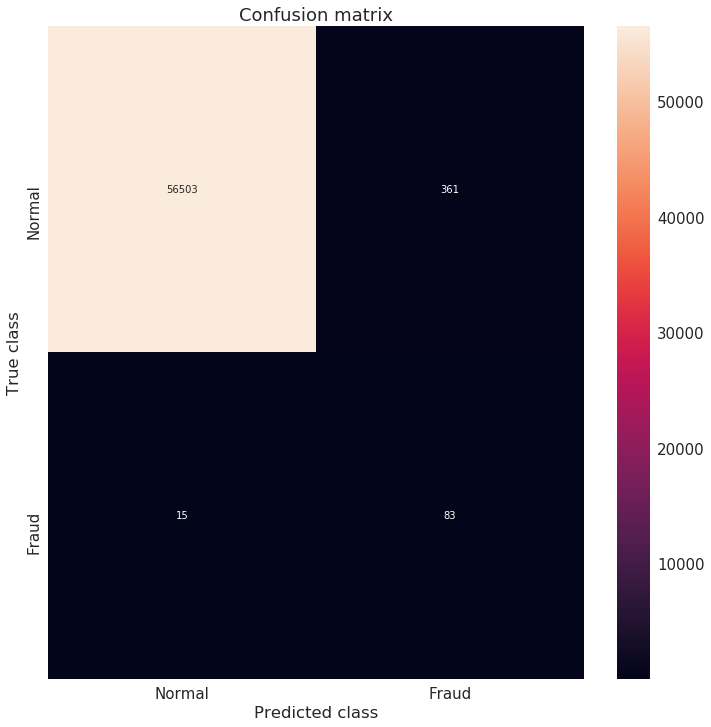

In [38]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [39]:
cohen_kappa_score(error_df.true_class, y_pred),accuracy_score(error_df.true_class, y_pred)

(0.30431210165014533, 0.9933991081773814)

The model manages to detect many fraudulent cases with accuracy over 99%. However, because of extreme prevalence Cohen's kappa gives a much more conservative evaluation. 